In [251]:
# Importation de la base de donnée, une seule feuille dans le fichier donc pas de pbl
import pandas as pd

df = pd.read_excel("NA.xlsx")
print(type(df))  # vérifier que c'est bien un DataFrame

# Conversion en datetime
Y_col = 'actual \nCountry Overshoot Day \n2018'
df[Y_col] = pd.to_datetime(df[Y_col], errors='coerce')

# Extraire jour et mois
df['day'] = df[Y_col].dt.day
df['month'] = df[Y_col].dt.month

# Concaténer mois et jour en format "MM-DD"
df['Overshoot_day_month'] = df['month'].astype(str).str.zfill(2) + "-" + df['day'].astype(str).str.zfill(2)

df = df.drop(columns=['day', 'month'])

print(df.columns) 
print(df['Overshoot_day_month'])


<class 'pandas.core.frame.DataFrame'>
Index(['Country', 'Quality Score', 'SDGi', 'Life Expectancy', 'HDI',
       'Per Capita GDP', 'Region', 'Income Group', 'Population (millions)',
       'Cropland Footprint', 'Grazing Footprint', 'Forest Product Footprint',
       'Fish Footprint', 'Built up land', 'Carbon Footprint',
       'Total Ecological Footprint (Production)', 'Cropland Footprint.1',
       'Grazing Footprint.1', 'Forest Product Footprint.1', 'Fish Footprint.1',
       'Built up land.1', 'Carbon Footprint.1',
       'Total Ecological Footprint (Consumption)', 'Cropland', 'Grazing land',
       'Forest land', 'Fishing ground', 'Built up land.2',
       'Total biocapacity ', 'Ecological (Deficit) or Reserve',
       'Number of Earths required', 'Number of Countries required',
       'actual \nCountry Overshoot Day \n2018', 'Overshoot_day_month'],
      dtype='object')
0       nan-nan
1      11.0-1.0
2       9.0-2.0
3       nan-nan
4       5.0-3.0
         ...   
179    8.0-28.0

Afficher le nombre de lignes et de colonnes :

In [233]:
# nombre de lignes :
print(len(df))

184


Il y a donc  184 pays.

In [234]:
# nombre de lignes :
print(len(df.columns))

34


Il y a donc 33 colonnes + Overshoot_day_month

Création de la vatiable de réponse Y et de la matrice de variables explicatives : X

In [252]:
Y_col = "Overshoot_day_month"
df['id'] = df.index + 1

id_stockage =df['id']

# X_cols ne prend pas la colonne nom_pays + prend l id pour retrouver les pays
cols_to_include = df.columns[1:-3] # pas les 2 overshoulday

cols = [col for col in cols_to_include if col != Y_col]

X_cols = ['id'] + list(cols_to_include)

print(len(X_cols)) # si 32 alors ok
id_stockage

32


0        1
1        2
2        3
3        4
4        5
      ... 
179    180
180    181
181    182
182    183
183    184
Name: id, Length: 184, dtype: int64

Génération du jeu de données du S1, sans aucune ligne contenant au mins une NA : 

In [253]:
import numpy as np

# on prend df en on supprime les lignes ou il y a des données NA parmis les X ou Y :

df["Per Capita GDP"] = (
    df["Per Capita GDP"]
    .replace("-", np.nan)
)

df["Overshoot_day_month"] = (
    df["Overshoot_day_month"]
    .replace("nan-nan", np.nan)
)

df["Per Capita GDP"] = pd.to_numeric(
    df["Per Capita GDP"], errors="coerce"
)

s_un = df.dropna(subset=X_cols + [Y_col])

print(len(s_un))

106


C:\Users\annac\AppData\Local\Temp\ipykernel_18148\3375722286.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("-", np.nan)


Nous avons donc 109 lignes

Pour réaliser les prédictions, commençons par séparer le jeu de données en X et Y :

In [254]:
# Séparation X / y
X = s_un[X_cols]
y = s_un[Y_col]

# Avant d'apprendre, il faut gerer les colonnes non numeriques : 
for col in X_cols: 
    if df[col].dtype == 'object': 
        print(col) 
        
# Il y a donc 3 colonnes a gerer, elles sont catégorielles :

categorical_cols = ['Quality Score', 'Region', 'Income Group']

# Encodage
X_encoded = pd.get_dummies(
    X,
    columns=categorical_cols,
    drop_first=True
)

print(y)


Quality Score
Region
Income Group
1       11.0-1.0
2        9.0-2.0
5       6.0-22.0
6      10.0-29.0
7       3.0-21.0
         ...    
173     3.0-11.0
174     5.0-17.0
175     3.0-11.0
177     10.0-9.0
180     9.0-10.0
Name: Overshoot_day_month, Length: 106, dtype: object


Nous avons maintenant X_encoded, regardons sont nombre de colonnes, normalement il a toujours 109 lignes

In [219]:
print(len(X_encoded))
print(len(X_encoded.columns))

106
40


In [255]:
# Avant tout, convertir la target en numérique :
import pandas as pd

def month_day_to_numeric(s):
    """Convert 'month-day' string with possible floats to day-of-year (year=2018)."""
    if pd.isna(s):
        return None
    try:
        # séparer mois et jour
        month_str, day_str = s.split('-')
        # convertir en float puis en int
        month = int(float(month_str))
        day = int(float(day_str))
        # créer la date avec année 2018
        dt = pd.Timestamp(year=2018, month=month, day=day)
        return dt.dayofyear
    except:
        return None

# Appliquer à la colonne
print(y)
y = y.apply(month_day_to_numeric)

# Vérifier
print(y.head(100))



1       11.0-1.0
2        9.0-2.0
5       6.0-22.0
6      10.0-29.0
7       3.0-21.0
         ...    
173     3.0-11.0
174     5.0-17.0
175     3.0-11.0
177     10.0-9.0
180     9.0-10.0
Name: Overshoot_day_month, Length: 106, dtype: object
1      305
2      245
5      173
6      302
7       80
      ... 
163    244
167     76
168    284
169    171
170    116
Name: Overshoot_day_month, Length: 100, dtype: int64


Il y a donc 41 colonnes, c'est bormale car en encodant, nous en avons créé de nouvelles

Maintenant que c'est fait, je split mon jeu de données afin de créer le train et le test :

In [246]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    # je separe en 20% test et 80% train
    test_size=0.2, 
    # j'ai mit une graine afin d'avoir toujours les mêmes résultats
    random_state=123
)


print(np.unique(X_train.dtypes))

[dtype('bool') dtype('int64') dtype('float64')]


In [ ]:
print(y_test[34])

151


Je crée le modèle linéaire :

In [269]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
train = model.fit(X_train, y_train)

# prédiction sur les données de X_test
y_pred = train.predict(X_test)
y_pred = y_pred.astype(int)  # convertit chaque élément en entier
print(y_pred)

[170  98 173 213 102 104 193 110 214  11 137  62 348 179 217 253  98 131
 327 239 308 132]


In [271]:
moyenne = np.mean(y_test-y_pred)
moyenne = moyenne.astype(int)
print(moyenne)

-18


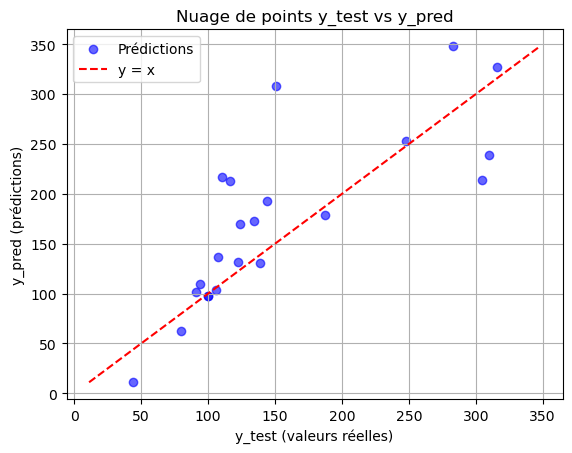

In [273]:
import matplotlib.pyplot as plt
import numpy as np

# Nuage de points
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Prédictions')

# Droite de régression y = x pour comparer
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

# Labels et titre
plt.xlabel('y_test (valeurs réelles)')
plt.ylabel('y_pred (prédictions)')
plt.title('Nuage de points y_test vs y_pred')
plt.legend()
plt.grid(True)
plt.show()
